# Forced bistability and bifurcation

In [40]:
include("simu_dual_utils.jl")
pyplot()
using LaTeXStrings    # for plot labels, etc.
using JLD2

## select species

Select some of the species
1. σ₁, 
2. A₁, 
3. σ₂, 
4. A₂, 
5. R, 
6. Rσ₁, 
7. Rσ₂ 
8. σ₁ + Rσ₁, 
9. σ₂ + Rσ₂, 
10. R + Rσ₁ + Rσ₂

## Function toplot vector field

In [4]:
function simple_vf(sol, stress_t, dt, β; hide_x = false)
    # beta is required for finding fps
    
    # get the vector field
    # each row is a certain σ, each col is an A
    dσdt, dAdt, ~, passage = vector_field(sol, stress_t, dt)
    
    # filter sparse grid points
    thres = 2e-4
    for i = 1:size(dσdt, 1)
        for j = 1:size(dσdt, 2)
            if passage[i, j] < thres * maximum(passage)
                dσdt[i, j] = dAdt[i, j] = 0.0
            end
        end
    end
    
    # shrink boundries
    magnitude = sqrt.(dσdt.^2 .+ dAdt.^2)
    # select the max non-zero index
    σ_max = maximum((1:size(dσdt, 1))[(sum(magnitude, dims = 2) .> 1e-16)[:]])
    A_max = maximum((1:size(dAdt, 2))[(sum(magnitude, dims = 1) .> 1e-16)[:]])
    σ_min = minimum((1:size(dσdt, 1))[(sum(magnitude, dims = 2) .> 1e-16)[:]])
    A_min = minimum((1:size(dAdt, 2))[(sum(magnitude, dims = 1) .> 1e-16)[:]])
    dσdt = dσdt[σ_min:σ_max, A_min:A_max]
    dAdt = dAdt[σ_min:σ_max, A_min:A_max]
    
    # decide the interval
    smaller_dim = min(size(dσdt)...)
    max_density = 10
    int = max(1, Int64(ceil(smaller_dim / max_density)))
    
    # sparsify
    σ_selected = 1:int:size(dσdt, 1)
    A_selected = 1:int:size(dσdt, 2)
    dσdt = dσdt[σ_selected, A_selected]
    dAdt = dAdt[σ_selected, A_selected]
    
    # get the grids
    σ_grid = σ_selected .* ones(size(dσdt)...) .- 1    # each row is 1,2,3...
    A_grid = A_selected' .* ones(size(dσdt)...) .- 1    # each col is 1,2,3...
    
    # normalize
    scale = 0.7
    new_mag = sqrt.(dσdt.^2 .+ dAdt.^2)
    for i = 1:size(dσdt, 1)
        for j = 1:size(dσdt, 2)
            if new_mag[i, j] > 1e-16    # to avoid divide by 0
                dσdt[i, j] = dσdt[i, j] / new_mag[i, j] * (scale * int)
                dAdt[i, j] = dAdt[i, j] / new_mag[i, j] * (scale * int)
            end
        end
    end
    
    # also show fixed points
    fp, ~, ~ = find_fp(sol, stress_t, dt, β, thres_v = 1.5e-3)
    
    # plot
    # transpose: map σ to y axis
    quiver(σ_grid[:], A_grid[:], quiver = (dσdt[:], dAdt[:]),
        aspect_ratio = :equal)
    plot!(framestyle = :box, grid = :none)
    plot!(ylabel = "A", xlabel = "σ")
        if hide_x
        plot!(xticks = false, xlabel = "")
    end
    # plot fps (green) (fp already starts from 0)
    scatter!(fp[:, 1], fp[:, 2], markersize = 8, color = :darkred, label = :none,
        markerstrokewidth = 0)
    # resize
    plot!(size = (200/A_max*σ_max, 200))
end
    

simple_vf (generic function with 1 method)

## Function to make parameter map

In [5]:
"""
Notice that the function is not meant to be a general one
settings are specific to the k1-KS map
"""
function para_map(behaviors, para_1, para_2;
    xlabel = "para_1", ylabel = "para_2")
    num_behaviors = zeros(Int64, size(behaviors)...)

    # het_activation or stochastic switching = bistability
    # homo_activation or stochastic_anti_pulsing = monostability activation
    sym2num = Dict(:oscillation => 1, :stochastic_pulsing => 2, :no_expression => 3,
        :stochastic_anti_pulsing => 4, :homo_activation => 4,
        :het_activation => 5, :stochastic_switching => 5,
        :irregular_oscillation => 6, :undefined => 7)
    color_grad = cgrad([:red, :yellow, :white, :darkblue, 
            :green, :orange, :black], categorical = true)

    for i = 1:size(behaviors, 1)
        for j = 1:size(behaviors, 2)
            num_behaviors[i, j] = sym2num[behaviors[i, j]]
        end
    end

    # assign the min/max since undefined is hardly encountered
    # color bar is messed up. not shown
    heatmap(para_1, para_2, num_behaviors', c = color_grad, framestyle = :box,
        yaxis = :log,
        yticks = (2. .^(0:5), 2. .^(0:5)),
        xlabel = xlabel, ylabel = ylabel, clim = (1, 7), legend = :none)
    plot!(size = (400, 300))
end

para_map

## Play around here

In [4]:
bs_line(k) = -4e3 * k + 25.
k₁_vec = range(1e-4, stop = 5e-3, length = 20)

0.0001:0.0002578947368421053:0.005

In [ ]:
# no competition scenario

# # settings
# stress_t = 1e3
# dt = 0.2
# # parameters
# β = 50.0
# n₁ = 1.0
# n₂ = 3.0
# Rₜ = 200    # total number of RNAP core
# k₁ = 5e-3
# k₂ = 5e-2
# KS = 0.1
# rK = 1.0

# # define the system
# network = duo_ts_system()

# # simulation
# sol = simu_duo_ts_all(network,
#     _KS₁ = 0.1, _rK₁ = 10., 
#     _KS₂ = 3., _rK₂ = 7.0,    # temp set to the same
#     _n₁ = n₁, _n₂ = n₂,
#     _Rₜ = Rₜ, 
#     _k₁₁ = 0.0001, _k₂₁ = k₂, 
#     _k₁₂ = 0.0001, _k₂₂ = k₂,
#     _β₁ = β, _β₂ = β, _τ₁ = 10.0, _rτ = 5.0,
#     max_t = 1e5, stress_t = stress_t, saveat = dt,
#     quiet = true);    # block any plots by default

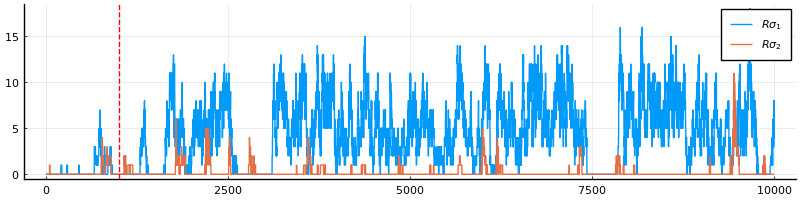

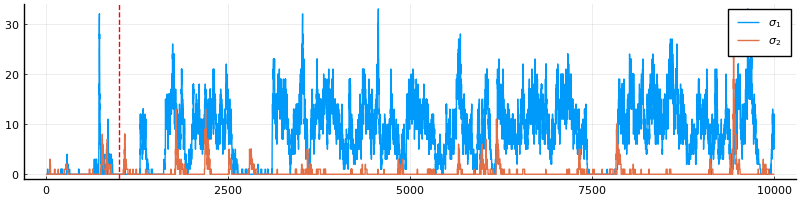

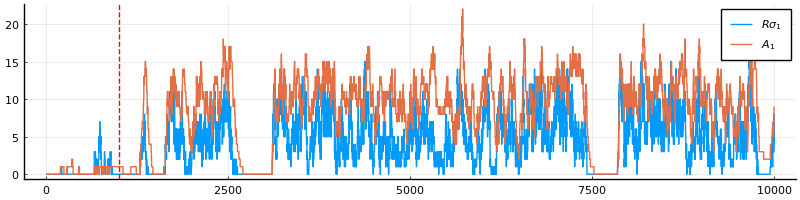

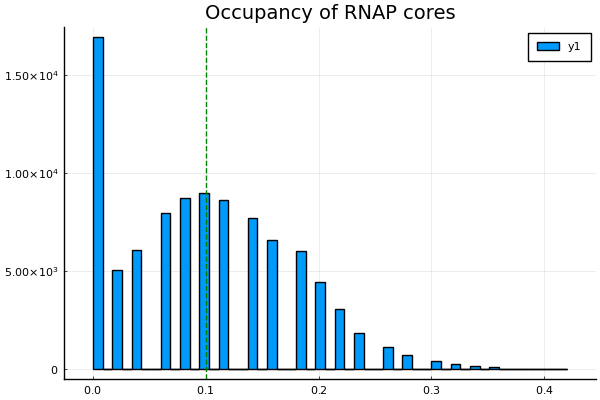

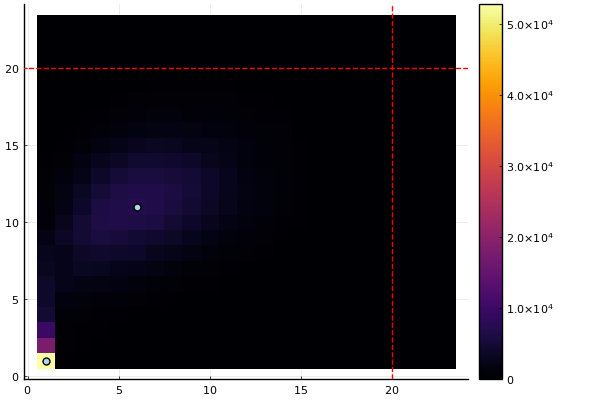

# fp: 1, # fp below noise level: 1, # fp above noise level: 0, has reverse flow: false, has forward flow: false
The dynamical behaviour is: no_expression

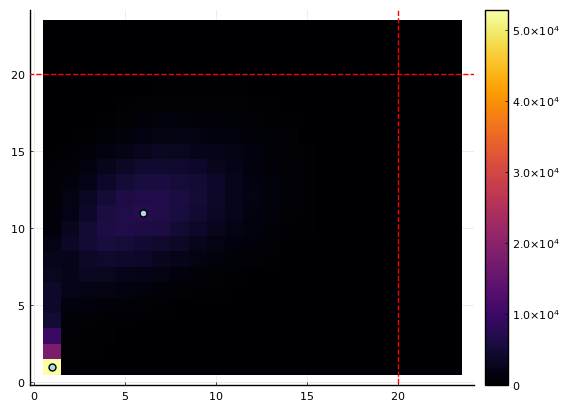


no_expression


In [365]:
pyplot()
# settings
stress_t = 1e3
dt = 0.2
# parameters
β = 100.0
n₁ = 1.0
n₂ = 1.0
Rₜ = 50    # total number of RNAP core

k₂ = 0.1    # k_off
k₁ = k₂ / 80    # k_on = k_off / K_d

KS = 2.0
rK = 0.22

# define the system
network = duo_ts_system()

# simulation
sol = simu_duo_ts_all(network,
    _KS₁ = KS, _rK₁ = rK, 
    _KS₂ = 10.0, _rK₂ = 1e-12,   # temp set to the same
    _n₁ = n₁, _n₂ = n₂,
    _Rₜ = Rₜ, 
    _k₁₁ = k₁, _k₂₁ = k₂, 
    _k₁₂ = k₁, _k₂₂ = k₂,
    _β₁ = β, _β₂ = β, _τ₁ = 10.0, _rτ = 5.0, _v₀ = 1e-3,
    max_t = 1e5, stress_t = stress_t, saveat = dt,
    quiet = true);    # block any plots by default

# select molecules
t, v₁, v₂ = interpret_sol(select_species(sol, [6, 7]))

pl = 50000
# plot
plot(t[1:pl], v₁[1:pl], label = L"R\sigma_1")
plot!(t[1:pl], v₂[1:pl], label = L"R\sigma_2")
plot!([stress_t], seriestype = "vline", color = "red", 
        linestyle = :dash, labels = :none)
plot!(size = (800, 200)) |> display

# plot another one
t, v₁, v₂ = interpret_sol(select_species(sol, [1, 3]))
plot(t[1:pl], v₁[1:pl], label = L"\sigma_1")
plot!(t[1:pl], v₂[1:pl], label = L"\sigma_2")
plot!([stress_t], seriestype = "vline", color = "red", 
        linestyle = :dash, labels = :none)
plot!(size = (800, 200)) |> display

# plot yet another one
t, v₁, v₂ = interpret_sol(select_species(sol, [6, 2]))
plot(t[1:pl], v₁[1:pl], label = L"R\sigma_1")
plot!(t[1:pl], v₂[1:pl], label = L"A_1")
plot!([stress_t], seriestype = "vline", color = "red", 
        linestyle = :dash, labels = :none)
plot!(size = (800, 200)) |> display

# plot the occupation ratio of RNAP cores
~, ~, R = interpret_sol(select_species(sol, [4, 5]))
X = 1 .- R[5000:100000] / Rₜ
bins = Int64(maximum(R[5000:100000]))
histogram(X, bins = range(minimum(X), stop = maximum(X), length = bins),
    title = "Occupancy of RNAP cores")
plot!([mean(X)], seriestype = "vline", color = :green,
    linestyle = :dash, label = :none) |> display

# classification
regime = classify_by_timetraj(
    select_species(sol, [6, 2]), stress_t, dt, β, 1.0,
    thres_v = 0.0015,
    quiet = false, show_p_heatmap = true)
println(regime)

## Better density plot and trajectories

In [183]:
ssol = select_species(sol, [6, 2]);

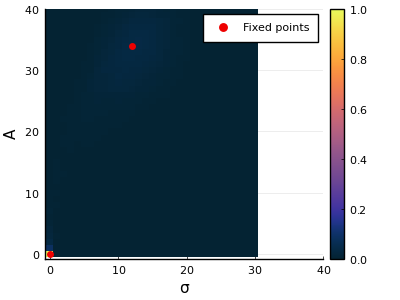

In [281]:
pyplot()
# get the density matrix
~, ~, ~, density = vector_field(ssol, stress_t, 1.0)
density = density ./ maximum(density)    # normalize between 0 and 1

# heatmap
heatmap((1:size(density, 1)) .- 1, (1:size(density, 2)) .- 1, density',
    c = cgrad(:thermal))

# plot fixed points
fp, ~, ~ = find_fp(ssol, stress_t, dt, β, thres_v = 1.5e-3)
scatter!(fp[:, 1], fp[:, 2],
    markersize = 5, markerstrokewidth = 0, color = :red2, label = "Fixed points")
xlims!(-0.75, 40)
ylims!(-0.75, 40)
plot!(xlabel = "σ", ylabel = "A")
plot!(size = (400, 300))

In [201]:
# savefig("density_forced_bs_k1_0004_Rt50.pdf")

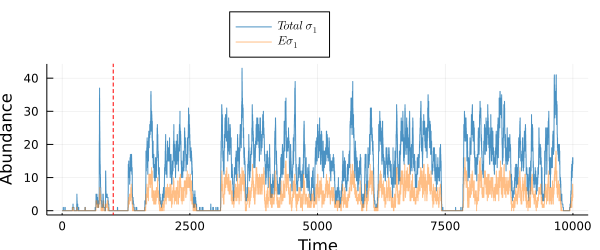

In [372]:
gr()
max_plot_t = 1e4
from = 1
to = Int64(max_plot_t / dt)

# select molecules
t, v₁, v₂ = interpret_sol(select_species(sol, [6, 8]))

plot(t[from:to], v₂[from:to], label = L"Total\;\sigma_1", alpha = 0.8, palette = :tab10)
plot!(t[from:to], v₁[from:to], label = L"E\sigma_1", alpha = 0.5, palette = :tab10)
plot!([stress_t], seriestype = "vline", color = "red", 
        linestyle = :dash, labels = :none)
plot!(size = (600, 250))
plot!(xlabel = "Time",
    ylabel = "Abundance")
plot!(legend = :outertop)
# plot!(xticks = :none, xlabel = "")

In [373]:
# savefig("traj_no_comp_both_k1_00001_Rt200.pdf")
# savefig("traj_sym_k1_0005_Rt_50_v0_0001_exclusive_act.pdf")
savefig("traj_both_nonus_kd80_Rt50_koff01.pdf")

### histogram

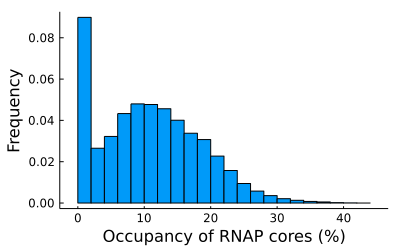

In [378]:
# collect free E
~, ~, R = interpret_sol(select_species(sol, [4, 5]))

from = Int64(round(stress_t/dt)) + 1
to = from - 1 + 100000

X = 100 * (1 + 1e-4 .- R[from:to] / Rₜ)
bins = length(unique(R))
histogram(X, bins = bins, normed = true, legend = false)
plot!(xlabel = "Occupancy of RNAP cores (%)", ylabel = "Frequency")
plot!(size = (400, 250))
plot!(grid = false)

In [379]:
savefig("hist_e_occu_both_nonus_kd80_Rt50_koff01.pdf")

## Inspect the vector field of $\sigma_1$

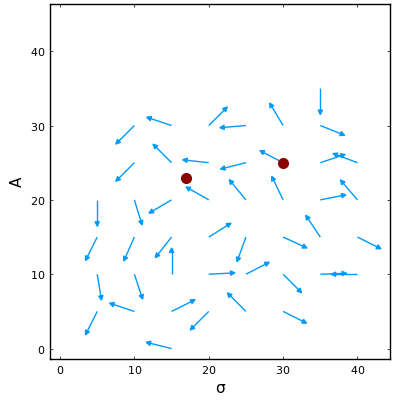

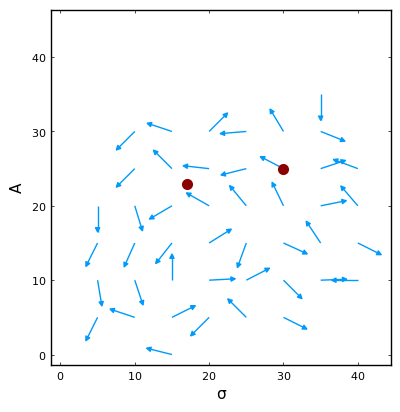

Distance between fps: 13.152946437965905


In [66]:
# select molecules
ssol = select_species(sol, [6, 2])

# plot vector field
simple_vf(ssol, stress_t, dt, β)
plot!(size = (400, 400)) |> display

# find fixed points
fp, ~, ~ = find_fp(ssol, stress_t, dt, β, thres_v = 1.5e-3)
if size(fp, 1) == 2
    println("Distance between fps: ", sqrt(sum((fp[1, :] .- fp[2, :]).^2)))
else
    println("#fp != 2")
end

## Change of parameter along association coefficient which makes stochastic switching possible

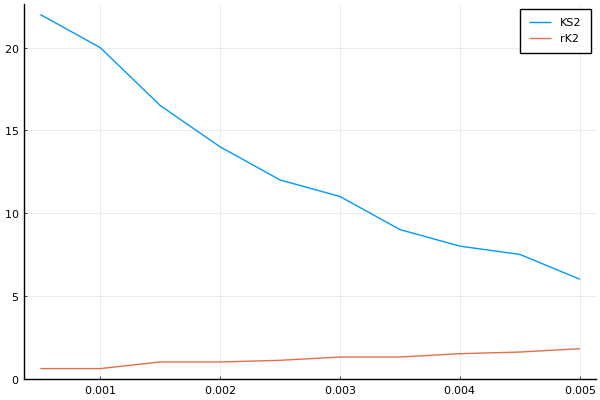

In [266]:
k11 = 0.005:-0.0005:0.0005
KS2 = [6., 7.5, 8., 9., 11., 12., 14., 16.5, 20., 22.]
rK2 = [1.8, 1.6, 1.5, 1.3, 1.3, 1.1, 1.0, 1.0, 0.6, 0.6]
plot(k11, KS2, label = "KS2")
plot!(k11, rK2, label = "rK2")

## Parameter map of $k_1$ and $K_S$

In [ ]:
# settings
stress_t = 1e3
dt = 0.2
# shared parameters
β = 50.0
Rₜ = 50    # total number of RNAP core
k₂ = 5e-2
rK = 1.0

# define the system
network = duo_ts_system()

# search space for parameters
k₁_vec = range(1e-4, stop = 5e-3, length = 20)
KS_vec = exp.(range(log(1.), stop = log(50.), length = 20))

# iteration
behaviors = Array{Symbol, 2}(undef, length(k₁_vec), length(KS_vec))    # initialize
for i = 1:length(k₁_vec)
    for j = 1:length(KS_vec)
        # simulation
        sol = simu_duo_ts_all(network,
            _KS₁ = KS_vec[j], _rK₁ = rK, 
            _KS₂ = KS_vec[j], _rK₂ = rK,    # temp set to the same
            _n₁ = 1.0, _n₂ = 3.0,
            _Rₜ = Rₜ, 
            _k₁₁ = k₁_vec[i], _k₂₁ = k₂, 
            _k₁₂ = 5e-3, _k₂₂ = k₂,
            _β₁ = β, _β₂ = β, _τ₁ = 10.0, _rτ = 5.0,
            max_t = 5e5, stress_t = stress_t, saveat = dt,
            quiet = true);    # block any plots
        
        # classification
        # over σ₁ (Rσ₁ and A₁)
        tot_it = (i - 1) * length(KS_vec) + j    # total iteration till now
        is_verbose = mod(tot_it, 10) == 1    # 1/10 print messages
        if is_verbose
            println("Simulation #", tot_it)
        end
        regime = classify_by_timetraj(    # classify σ₂, the cooperative one
            select_species(sol, [7, 4]), stress_t, dt, β, 3.0,
            thres_v = 0.0015,    # permissive vf threshold, higher flow position
            quiet = !is_verbose)
        behaviors[i, j] = regime
    end
end


Simulation #1
# fp: 1, # fp below noise level: 0, # fp above noise level: 1, has reverse flow: false, has forward flow: false
The dynamical behaviour is: homo_activation
Simulation #11


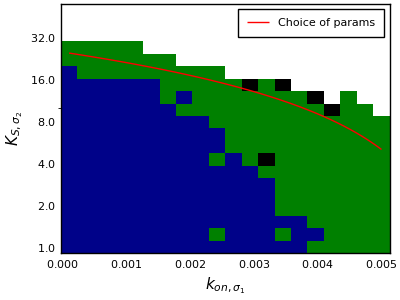

In [300]:
# # loding data
behaviors = load("k1_KS_map_20.jld2", "behaviors")
k₁_vec = range(1e-4, stop = 5e-3, length = 20)
KS_vec = exp.(range(log(1.), stop = log(50.), length = 20))

p = para_map(behaviors, k₁_vec, KS_vec, xlabel = L"k_{on,\sigma_1}", ylabel = L"K_{S,\sigma_2}")
_xlims = xlims(p)
_ylims = ylims(p)    # save axis lims
# why not using k₁_vec? the curve is not smooth enough
X = range(minimum(k₁_vec), stop = maximum(k₁_vec), length = 50)
bs_line(x) = -4e3 * x + 25.
plot!(p, X, bs_line.(X), color = :red,
    xlims = _xlims, ylims = _ylims, 
    label = "Choice of params", legend = true)

In [301]:
savefig(p, "k1_KS_map_20.pdf")

## Bifircation diagram

In [286]:
# settings
stress_t = 1e3
dt = 0.2
# shared parameters
β = 50.0
Rₜ = 50    # total number of RNAP core
k₂ = 5e-2
rK = 1.0

# define the system
network = duo_ts_system()

# search space for parameters
k₁_vec = range(1e-4, stop = 5e-3, length = 500)

# find the corresponding KS that keeps
# σ₂ in bistability
bs_line(k) = -4e3 * k + 25.

# iteration
fps = zeros(Float64, 3 * length(k₁_vec), 2)   # initialize
n_fp = 0    # number of fp recorded
for i = 1:length(k₁_vec)
    # find the KS that will keep σ₂ in bistability
    KS = bs_line(k₁_vec[i])
    
    # simulation
    sol = simu_duo_ts_all(network,
        _KS₁ = KS, _rK₁ = rK, 
        _KS₂ = KS, _rK₂ = rK,    # temp set to the same
        _n₁ = 1.0, _n₂ = 3.0,
        _Rₜ = Rₜ, 
        _k₁₁ = k₁_vec[i], _k₂₁ = k₂, 
        _k₁₂ = 5e-3, _k₂₂ = k₂,
        _β₁ = β, _β₂ = β, _τ₁ = 10.0, _rτ = 5.0,
        max_t = 1e6, stress_t = stress_t, saveat = dt,
        quiet = true);    # block any plots

    # iteration counts
    println("Simulation #", i)
    
    # find fixed points
    # select for Rσ₁ and A₁ (non-cooperative)
    fp, ~, ~ = find_fp(select_species(sol, [6, 2]),
            stress_t, dt, β, thres_v = 1.5e-3)
    for j = 1:size(fp, 1)
        n_fp += 1
        fps[n_fp, :] .= [k₁_vec[i], fp[j, 1]]
    end
    # report
    println("Found ", size(fp, 1), " fixed points")
end

fps = fps[1:n_fp, :];    # truncate

Simulation #1
Found 1 fixed points
Simulation #2
Found 1 fixed points
Simulation #3
Found 1 fixed points
Simulation #4
Found 1 fixed points
Simulation #5
Found 1 fixed points
Simulation #6
Found 1 fixed points
Simulation #7
Found 1 fixed points
Simulation #8
Found 1 fixed points
Simulation #9
Found 1 fixed points
Simulation #10
Found 1 fixed points
Simulation #11
Found 1 fixed points
Simulation #12
Found 1 fixed points
Simulation #13
Found 1 fixed points
Simulation #14
Found 1 fixed points
Simulation #15
Found 1 fixed points
Simulation #16
Found 1 fixed points
Simulation #17
Found 1 fixed points
Simulation #18
Found 1 fixed points
Simulation #19
Found 1 fixed points
Simulation #20
Found 1 fixed points
Simulation #21
Found 1 fixed points
Simulation #22
Found 1 fixed points
Simulation #23
Found 1 fixed points
Simulation #24
Found 1 fixed points
Simulation #25
Found 1 fixed points
Simulation #26
Found 1 fixed points
Simulation #27
Found 1 fixed points
Simulation #28
Found 1 fixed points
S

Found 3 fixed points
Simulation #226
Found 3 fixed points
Simulation #227
Found 3 fixed points
Simulation #228
Found 3 fixed points
Simulation #229
Found 3 fixed points
Simulation #230
Found 3 fixed points
Simulation #231
Found 3 fixed points
Simulation #232
Found 3 fixed points
Simulation #233
Found 3 fixed points
Simulation #234
Found 3 fixed points
Simulation #235
Found 3 fixed points
Simulation #236
Found 3 fixed points
Simulation #237
Found 3 fixed points
Simulation #238
Found 3 fixed points
Simulation #239
Found 3 fixed points
Simulation #240
Found 3 fixed points
Simulation #241
Found 3 fixed points
Simulation #242
Found 3 fixed points
Simulation #243
Found 3 fixed points
Simulation #244
Found 3 fixed points
Simulation #245
Found 3 fixed points
Simulation #246
Found 3 fixed points
Simulation #247
Found 3 fixed points
Simulation #248
Found 3 fixed points
Simulation #249
Found 3 fixed points
Simulation #250
Found 3 fixed points
Simulation #251
Found 3 fixed points
Simulation #252
F

Simulation #447
Found 2 fixed points
Simulation #448
Found 2 fixed points
Simulation #449
Found 2 fixed points
Simulation #450
Found 2 fixed points
Simulation #451
Found 2 fixed points
Simulation #452
Found 2 fixed points
Simulation #453
Found 2 fixed points
Simulation #454
Found 2 fixed points
Simulation #455
Found 2 fixed points
Simulation #456
Found 2 fixed points
Simulation #457
Found 2 fixed points
Simulation #458
Found 2 fixed points
Simulation #459
Found 2 fixed points
Simulation #460
Found 2 fixed points
Simulation #461
Found 2 fixed points
Simulation #462
Found 2 fixed points
Simulation #463
Found 2 fixed points
Simulation #464
Found 2 fixed points
Simulation #465
Found 2 fixed points
Simulation #466
Found 2 fixed points
Simulation #467
Found 2 fixed points
Simulation #468
Found 2 fixed points
Simulation #469
Found 2 fixed points
Simulation #470
Found 2 fixed points
Simulation #471
Found 2 fixed points
Simulation #472
Found 2 fixed points
Simulation #473
Found 2 fixed points
S

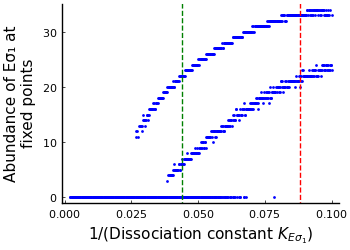

In [294]:
pyplot()
scatter(1.0 ./ (0.05 ./ fps[:, 1]), fps[:, 2],
    color = :blue, markersize = 2, markerstrokewidth = 0)
plot!(grid = false, legend = :none)
plot!(xlabel = "1/(Dissociation constant "*L"K_{E\sigma_1}"*")",
    ylabel = "Abundance of Eσ₁ at\nfixed points")
plot!(size = (350, 250))
plot!([0.0022/0.05, 0.0044/0.05], seriestype = :vline, linestyle = :dash,
    color = [:green, :red, :red, :red, :red], label = :none)
# scatter!([0.0022, 0.004], [-0.5, -0.5], markershape = :utriangle, 
#     markersize = 5, markercolor = false, markerstrokecolor = [:green, :red])

In [296]:
save("bifurcation_data_Esigma1_kons1.jld2", Dict("fps" => fps))

In [295]:
savefig("bifurcation_forced.pdf")